In [1]:
'''
New attempt at processing data

Goals: 
- Acknowledge the existence of 2 needed corrections 
    1. DC offset 
    2. Multiplier 

Methods: 
- Use S2c data to calculate for DC offset (curve fit) 
    Curve will take the form of y = a + exp(bx), note that this is not the actual equation but rather the 2DEG 
- Subtract DC offset from raw data and and multiply values with multiplier 
    After determining the value of a, apply (S2-a)*multiplier 
    Multiplier = S2c/S2 
- Return corrected data (apply best fit which should just be the exponential term in 2DEG)
''' 


'\nNew attempt at processing data\n\nGoals: \n- Acknowledge the existence of 2 needed corrections \n    1. DC offset \n    2. Multiplier \n\nMethods: \n- Use S2c data to calculate for DC offset (curve fit) \n    Curve will take the form of y = a + exp(bx), note that this is not the actual equation but rather the 2DEG \n- Subtract DC offset from raw data and and multiply values with multiplier \n    After determining the value of a, apply (S2-a)*multiplier \n    Multiplier = S2c/S2 \n- Return corrected data (apply best fit which should just be the exponential term in 2DEG)\n'

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import os
import os.path

Wavelength    float64
S2c           float64
dtype: object


<AxesSubplot:xlabel='Wavelength'>

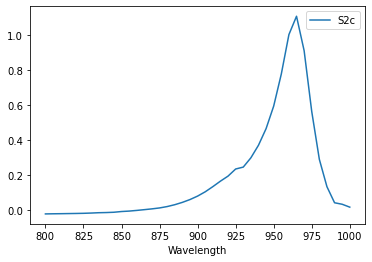

In [29]:
os.getcwd()
path = "/Users/luke/Desktop/python_project/GitClone/Automate-Research-Process/testfolder"
data_list = os.listdir(path)
test_df = pd.read_csv(path+f"/{data_list[11]}") #For future uses, we will be doing for loop for the entire directory, so there won't be a need to selectively choose the index 
col = test_df.columns

new_df = pd.DataFrame() 
new_df['Wavelength'] = test_df['Wavelength'].iloc[1:]
new_df['S2c'] = test_df['S2c'].iloc[1:]
#print(new_df)

new_df = new_df.astype(float)
print(new_df.dtypes)
new_df.plot(x='Wavelength',  y='S2c')
# plt.scatter(test_df[col[1].iloc[1,31]], test_df[col[0]].iloc[1,31])
# plt.show()


